Projet Python 2025

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("alertes_enrichies.csv")
df.head()


,Titre Alerte,Lien Alerte,Date Alerte,CVE ID,Description CVE,CWE,Nature de la faille,Score CVSS,Gravité CVSS,Score EPSS,Gravité EPSS,Éditeur,Produit,Versions Affectées
0,Multiples vulnérabilités dans MISP (08 décembr...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mon, 08 Dec 2025 00:00:00 +0000",CVE-2025-67906,"In MISP before 2.5.28, app/View/Elements/Workf...",CWE-79,CWE-79 Improper Neutralization of Input During...,5.4,Moyenne,0.00035,Faible,MISP,MISP,0
1,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Thu, 11 Dec 2025 00:00:00 +0000",CVE-2025-14372,Use after free in Password Manager in Google C...,CWE-416,Use after free,NaN,Non disponible,0.00040,Faible,Google,Chrome,143.0.7499.110
2,Multiples vulnérabilités dans Microsoft Edge (...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Fri, 12 Dec 2025 00:00:00 +0000",CVE-2025-14372,Use after free in Password Manager in Google C...,CWE-416,Use after free,NaN,Non disponible,0.00040,Faible,Google,Chrome,143.0.7499.110
3,Multiples vulnérabilités dans les produits Ela...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mon, 15 Dec 2025 00:00:00 +0000",CVE-2025-37731,Improper Authentication in Elasticsearch PKI r...,CWE-287,CWE-287 Improper Authentication,6.8,Moyenne,0.00036,Faible,Elastic,Elasticsearch,"7.0.0, 8.0.0, 9.0.0, 9.2.0"
4,Multiples vulnérabilités dans Roundcube (15 dé...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mon, 15 Dec 2025 00:00:00 +0000",CVE-2025-68460,Roundcube Webmail before 1.5.12 and 1.6 before...,CWE-116,CWE-116 Improper Encoding or Escaping of Output,7.2,Élevée,0.00048,Faible,Roundcube,Webmail,"0, 1.6.0"


Etape 5 : Interprétation et visualisation

Shape: (38, 14)
Valeurs manquantes par colonne:
 Titre Alerte            0
Lien Alerte             0
Date Alerte             0
CVE ID                  0
Description CVE         2
CWE                     0
Nature de la faille     2
Score CVSS             23
Gravité CVSS            0
Score EPSS              2
Gravité EPSS            0
Éditeur                 2
Produit                 2
Versions Affectées      2
dtype: int64


C:\Users\massi\AppData\Local\Temp\ipykernel_18820\191739847.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  alerts_per_month = ts.resample('M').size()


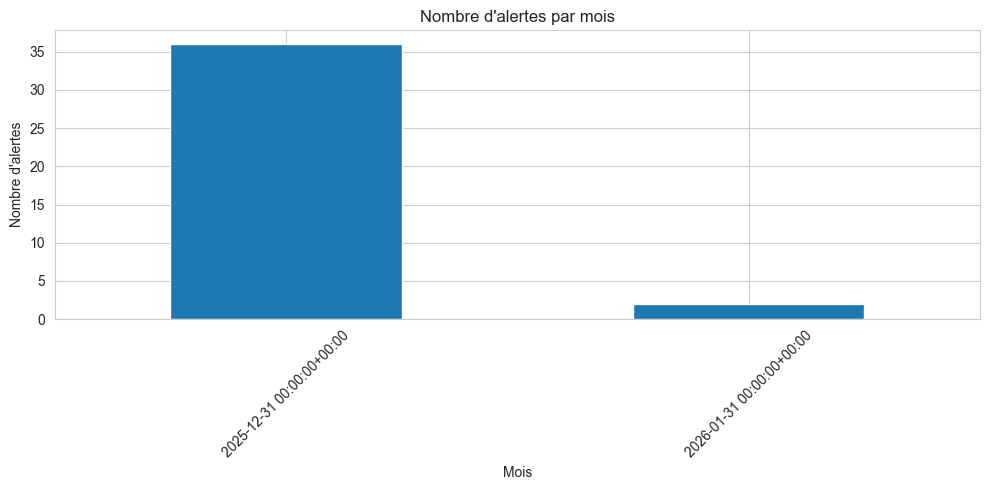

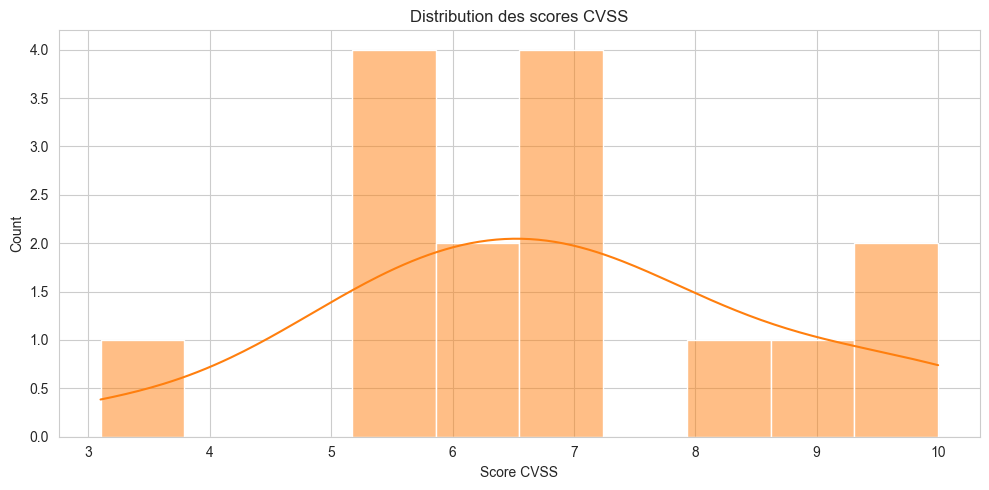

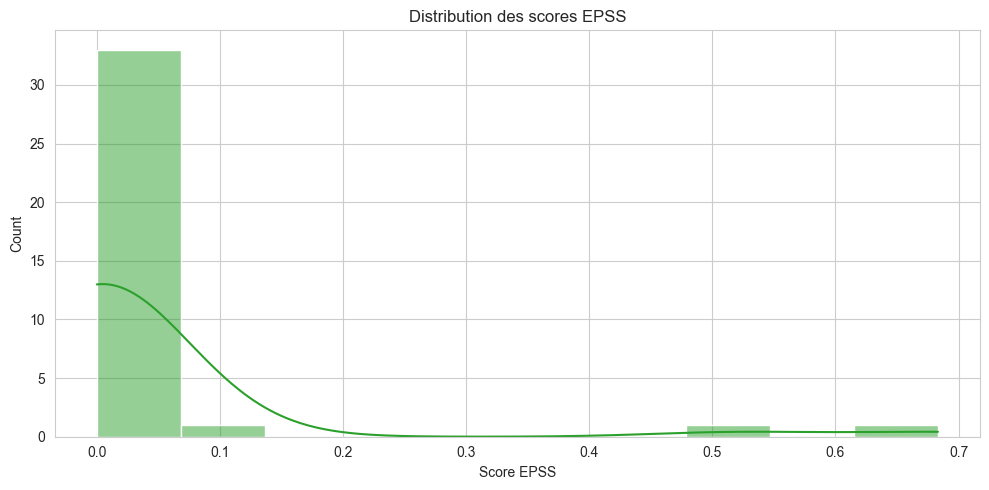

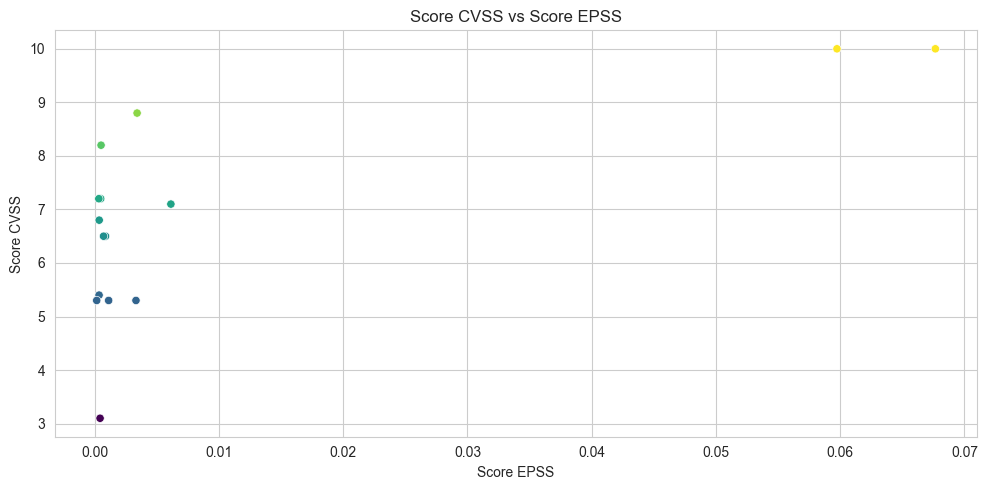

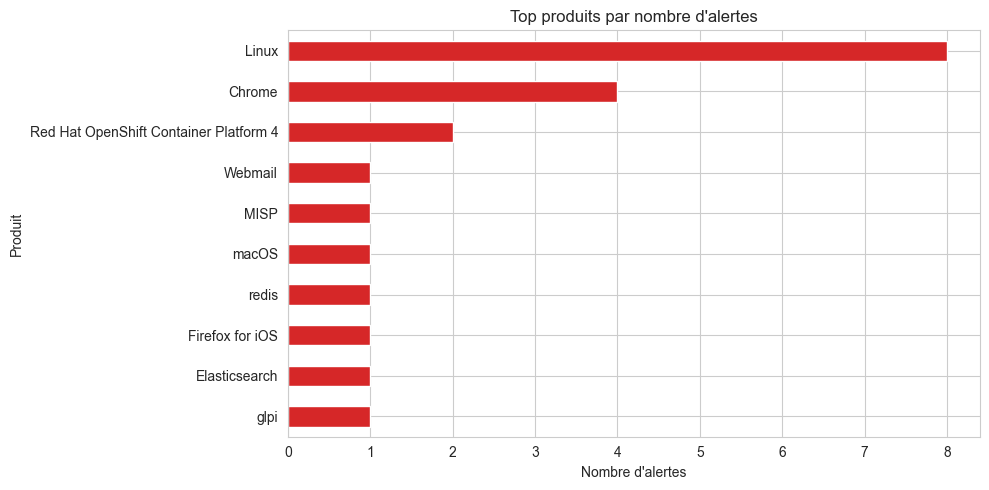

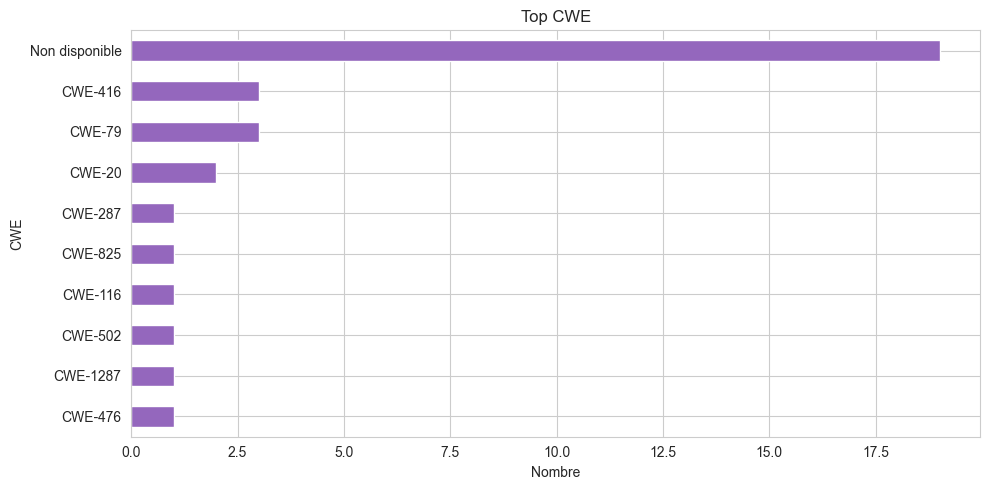

Nombre d'alertes Critiques/Élevées identifiées: 4
CVE-2025-49844 | CVSS: 10.0 (Critique) | EPSS: 0.05974 (Faible) | Produit: redis
CVE-2025-23006 | CVSS: nan (Non disponible) | EPSS: 0.52066 (Élevée) | Produit: SMA1000
CVE-2025-20393 | CVSS: 10.0 (Critique) | EPSS: 0.06766 (Faible) | Produit: Cisco Secure Email and Web Manager
CVE-2025-14847 | CVSS: nan (Non disponible) | EPSS: 0.68325 (Élevée) | Produit: MongoDB Server


,CVE ID,Score CVSS,Gravité CVSS,Produit
8,CVE-2025-49844,10.0,Critique,redis
14,CVE-2025-20393,10.0,Critique,Cisco Secure Email and Web Manager
30,CVE-2025-62164,8.8,Élevée,vllm
19,CVE-2025-43865,8.2,Élevée,react-router
29,CVE-2025-68385,7.2,Élevée,Kibana
4,CVE-2025-68460,7.2,Élevée,Webmail
37,CVE-2023-6378,7.1,Élevée,logback
3,CVE-2025-37731,6.8,Moyenne,Elasticsearch
12,CVE-2025-59935,6.5,Moyenne,glpi
15,CVE-2025-12689,6.5,Moyenne,Mattermost


Répartition des niveaux de risque calculés:
Niveau de risque calculé
Faible/Non disponible    24
Moyenne                   7
Élevée                    5
Critique                  2
Name: count, dtype: int64

Exemples d'interprétations (top 10 par niveau de risque & EPSS):
CVE-2023-6378: Multiples vulnérabilités dans les produits IBM (02 janvier 2026)... -> Niveau: Élevée, CVSS: 7.1, EPSS: 0.00613
CVE-2025-62164: Multiples vulnérabilités dans VMware Tanzu Platform (26 décembre 2025)... -> Niveau: Élevée, CVSS: 8.8, EPSS: 0.00341
CVE-2025-43865: Multiples vulnérabilités dans Centreon Web (19 décembre 2025)... -> Niveau: Élevée, CVSS: 8.2, EPSS: 0.00051
CVE-2025-68460: Multiples vulnérabilités dans Roundcube (15 décembre 2025)... -> Niveau: Élevée, CVSS: 7.2, EPSS: 0.00048
CVE-2025-68385: Multiples vulnérabilités dans les produits Elastic (19 décembre 2025)... -> Niveau: Élevée, CVSS: 7.2, EPSS: 0.00033
CVE-2024-25126: Multiples vulnérabilités dans les produits VMware (19 décembre 2025)..

In [28]:
# Parcours et interprétation du dataframe + visualisations (utilise pd, plt, sns déjà importés)

# 1) Pré-traitement
df['Date Alerte'] = pd.to_datetime(df['Date Alerte'], errors='coerce')  # parser la date
print("Shape:", df.shape)
print("Valeurs manquantes par colonne:\n", df.isnull().sum())

# 2) Série temporelle: nombre d'alertes par mois
ts = df.set_index('Date Alerte').sort_index()
alerts_per_month = ts.resample('M').size()
alerts_per_month.plot(kind='bar', color='C0')
plt.title("Nombre d'alertes par mois")
plt.ylabel("Nombre d'alertes")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Distribution des scores CVSS et EPSS
plt.figure()
sns.histplot(df['Score CVSS'].dropna(), bins=10, kde=True, color='C1')
plt.title("Distribution des scores CVSS")
plt.xlabel("Score CVSS")
plt.tight_layout()
plt.show()

plt.figure()
sns.histplot(df['Score EPSS'].dropna(), bins=10, kde=True, color='C2')
plt.title("Distribution des scores EPSS")
plt.xlabel("Score EPSS")
plt.tight_layout()
plt.show()

# 4) Corrélation/nuage: Score EPSS vs Score CVSS (points avec deux scores disponibles)
scatter_df = df[['CVE ID', 'Score CVSS', 'Score EPSS']].dropna()
plt.figure()
sns.scatterplot(data=scatter_df, x='Score EPSS', y='Score CVSS', hue='Score CVSS', palette='viridis', legend=False)
plt.title("Score CVSS vs Score EPSS")
plt.xlabel("Score EPSS")
plt.ylabel("Score CVSS")
plt.tight_layout()
plt.show()

# 5) Top produits / éditeurs / CWE (comptages)
plt.figure()
df['Produit'].value_counts().nlargest(10).plot(kind='barh', color='C3')
plt.title("Top produits par nombre d'alertes")
plt.xlabel("Nombre d'alertes")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure()
df['CWE'].value_counts().nlargest(10).plot(kind='barh', color='C4')
plt.title("Top CWE")
plt.xlabel("Nombre")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 6) Filtrer les alertes critiques / élevées pour inspection
crit_mask = (
    (df['Score CVSS'].fillna(-1) >= 9) |
    (df['Gravité CVSS'].str.contains('Critique', na=False)) |
    (df['Gravité EPSS'].str.contains('Élevée', na=False))
)
crit_alerts = df[crit_mask]
print(f"Nombre d'alertes Critiques/Élevées identifiées: {len(crit_alerts)}")
for _, r in crit_alerts.iterrows():
    print(f"{r['CVE ID']} | CVSS: {r['Score CVSS']} ({r['Gravité CVSS']}) | EPSS: {r['Score EPSS']} ({r['Gravité EPSS']}) | Produit: {r['Produit']}")

# 7) Classement par score CVSS (top 10)
top_cvss = df.sort_values('Score CVSS', ascending=False).head(10)[['CVE ID','Score CVSS','Gravité CVSS','Produit']]
display(top_cvss)

# 8) Interprétation simple: calcul d'un niveau de risque à partir du CVSS
def niveau_risque(row):
    sc = row['Score CVSS']
    if pd.notna(sc):
        if sc >= 9:
            return 'Critique'
        if sc >= 7:
            return 'Élevée'
        if sc >= 4:
            return 'Moyenne'
    return 'Faible/Non disponible'

df['Niveau de risque calculé'] = df.apply(niveau_risque, axis=1)
print("Répartition des niveaux de risque calculés:")
print(df['Niveau de risque calculé'].value_counts())

# 9) exemples d'interprétations (quelques lignes)
print("\nExemples d'interprétations (top 10 par niveau de risque & EPSS):")
for _, r in df.sort_values(['Niveau de risque calculé','Score EPSS'], ascending=[False, False]).head(10).iterrows():
    print(f"{r['CVE ID']}: {r['Titre Alerte'][:80]}... -> Niveau: {r['Niveau de risque calculé']}, CVSS: {r['Score CVSS']}, EPSS: {r['Score EPSS']}")